## Optimal Market Making Strategy Simulation

#### As discussed in "Algorithmic and High Frequency Trading" by Cartea, Jaimungal, Penalva

In [14]:
# Necessary Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
%matplotlib inline
import seaborn as sns
import math
sns.set()
plt.rcParams["figure.figsize"] = (20,7)

# Model Parameters
S0 = 100 # Starting Midprice
lam = [1.0,1.0] # Intensities of Market Order Poisson Times
kappa = (100,100) 
q = (-10,10) # Bounds on Inventory, index 0 is the lower bound and 1 is the upper bound
phi = 2*(10**-4) # Running Inventory Penalty Parameter
alpha = 10**(-4) # Fees for taking liquidity as well as the impact of the MO walking LOB
sigma = 0.001
T = 300 # Number of Time Steps
num_steps = 1000 # Steps within each T for discretization
num_steps = num_steps+1 

### Generating Geometric Brownian Motion for the Midprice

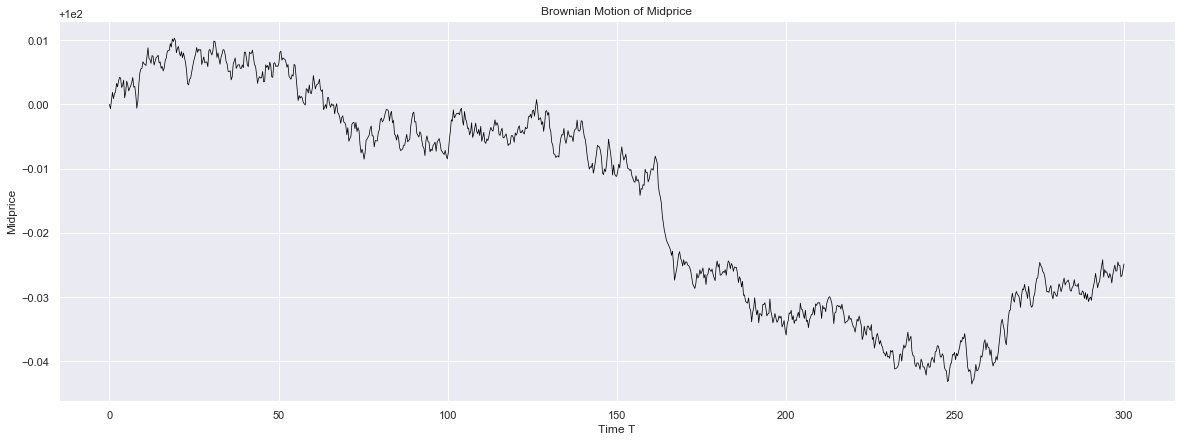

In [15]:
#Generating Geometric Brownian Motion
steps = np.linspace(0,T,num_steps,endpoint = True)
W_t = np.cumsum(np.random.normal(0,1,num_steps-1)) # Weiner Process
W_t = np.insert(W_t,0,0,axis=0)
S_t = S0+sigma*W_t #Addition of our stock price
S_t = pd.DataFrame([steps,S_t]).T #Creates a dataframe of the steps and corresponding S_t values
plt.plot(S_t.iloc[:,0],S_t.iloc[:,1],label='Midprice',color='black',linewidth=0.75)
plt.title('Brownian Motion of Midprice')
plt.xlabel('Time T')
plt.ylabel('Midprice')
plt.show()

### Generating Buy and Sell Market Orders as Poisson Processes

In [16]:
# Creating Poisson Processes For Market Orders (Buy and Sell)
M_buy = np.random.poisson(lam[1]*T)
M_sell = np.random.poisson(lam[0]*T)

#Finding and sorting the arrival time locations
loc_buy = sorted(np.random.uniform(0,T,M_buy))
loc_sell = sorted(np.random.uniform(0,T,M_sell))
# 
#Assigning the new values for M_buy and M_sell using steps (Conform to Discretization)
for i in range(len(loc_buy)):
    for t in range(len(steps)-1,0,-1):
        if loc_buy[i]>=steps[t]:
            loc_buy[i] = steps[t]
            break

for i in range(len(loc_sell)):
    for t in range(len(steps)-1,0,-1):
        if loc_sell[i]>=steps[t]:
            loc_sell[i] = steps[t]
            break

In [17]:
#Solving the DPE for Matrix A
A = []
for i in range(q[1],q[0]-1,-1):
    temp= []
    for j in range(q[1],q[0]-1,-1):
        if j==i:
            temp.append(-phi*kappa[0]*((j)**2))
        elif j-1 == i:
            temp.append(lam[1]*(np.exp(-1)))
        elif j+1 == i:
            temp.append(lam[0]*(np.exp(-1)))
        else:
            temp.append(0.0)
    A.append(temp)


In [18]:
# Constructing Vector z
Z = [np.exp(-1*alpha*kappa[0]*(j**2)) for j in range(q[1],q[0]-1,-1)]


In [19]:
#Construct Omega 10.11 on pg.249
omega = []
for t in S_t.iloc[:,0]:
    omega.append(expm(np.multiply(A,(T-t))).dot(Z))

In [20]:
# Construct h
h = []
for i in range(len(omega)):
    h.append([])
    for j in range(len(omega[i])):
        h[i].append((1/kappa[0])*np.log(omega[i][j]))

In [21]:
#Construct Deltas

#Delta Plus : Range for sell LO
delta_plus = []
for i in range(0,len(h)):
    delta_plus.append([])
    for j in range(len(h[i])):
        if j - q[1] == q[0]: # Sell, going over bound
            delta_plus[i].append(np.Inf)
        else:
            delta_plus[i].append((1/kappa[0]) - h[i][j-1]+h[i][j])
            
#Delta Minus: Range for buy MO
delta_minus = []
for i in range(0,len(h)):
    delta_minus.append([])
    for j in range(len(h[i])):
        if j - q[1] != q[1]: #Buy going over bound
            delta_minus[i].append((1/kappa[0]) - h[i][j+1]+h[i][j])
        else:
            delta_minus[i].append(np.Inf)
            

In [22]:
# Building out Mu (Expected Drift of Inventories)
Mu = []
for i in range(len(delta_plus)):
    Mu.append([])
    for j in range(len(delta_plus[i])):
        Mu[i].append(lam[1]*np.exp(-kappa[1]*delta_minus[i][j]) - lam[0]*np.exp(-kappa[0]*delta_plus[i][j]))


### Plotting the Buy and Sell Optimal Limit Order Depths

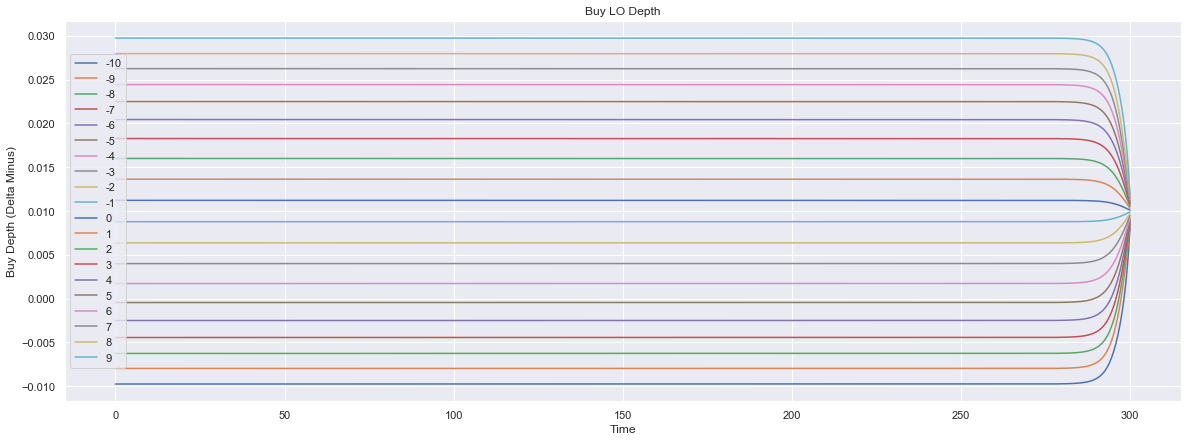

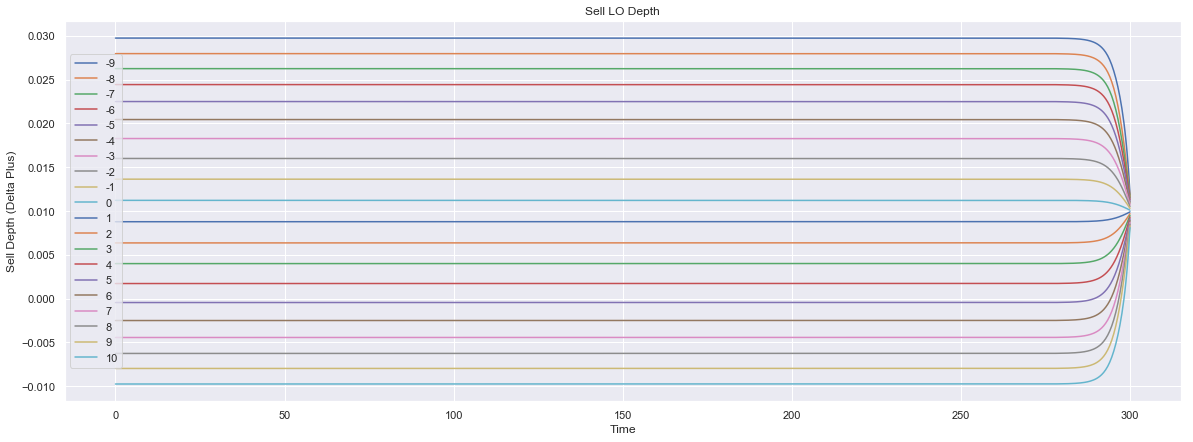

In [23]:
# The Depths for each inventory level over time
sell_lo_depth = pd.DataFrame(delta_plus) 
buy_lo_depth = pd.DataFrame(delta_minus)

for i in range(len(buy_lo_depth.iloc[0,:])):
    if(buy_lo_depth.iloc[:,i][0]!=np.Inf):
        plt.plot(S_t.iloc[:,0],buy_lo_depth.iloc[:,i],label = str(i-((q[1]-q[0])//2)))
        
plt.title("Buy LO Depth")
plt.xlabel("Time")
plt.ylabel("Buy Depth (Delta Minus)")
plt.legend()
plt.show()

for i in range(len(sell_lo_depth.iloc[0,:])):
    if(sell_lo_depth.iloc[:,i][0]!=np.Inf):
        plt.plot(S_t.iloc[:,0],sell_lo_depth.iloc[:,i],label = str(i-((q[1]-q[0])//2)))
        
plt.title("Sell LO Depth")
plt.xlabel("Time")
plt.ylabel("Sell Depth (Delta Plus)")
plt.legend()
plt.show()


In [24]:
# Plotting Inventory Process
inv = (q[1]-q[0])//2
inv_vals = []
wealth = 0


# Capping the values so our probability space is legitimate
for i in range(len(delta_minus)):
    for j in range(len(delta_minus[0])):
        if delta_minus[i][j]<0:
            delta_minus[i][j]=0
        if delta_plus[i][j]<0:
            delta_plus[i][j]=0

#For Plotting the filled orders
sell_lo_executed_x= []
sell_lo_executed_y= []

buy_lo_executed_x = []
buy_lo_executed_y = []

#Plotting The Optimal Depths
path_delta_minus = []
path_delta_plus = []

#Plotting the Cash Process
cash = 0
cash_path = []
final_price = S_t.iloc[:,1][len(S_t.iloc[:,1])-1]

# For every timestep t
for t in range(len(S_t[0])):
    mid_price = S_t.iloc[:,1][t]
    inv_change = 0
    cash_change = 0
    path_delta_plus.append(mid_price+delta_minus[t][inv])
    path_delta_minus.append(mid_price - delta_minus[t][inv])
    
    for b in loc_buy:
        if S_t[0][t] == b: #If we have a buy MO location at this step
            pFill_buy = np.exp(-kappa[1]*delta_plus[t][inv]) #Calculate Fill probability
            if np.random.binomial(1,pFill_buy) == 1:        # Sample from binomial to see if we actually fill
                inv_change-=1 #filling a buy MO means we are the seller (a sell LO was lifted by a buy MO)
                sell_lo_executed_x.append(S_t[0][t])
                sell_lo_executed_y.append(mid_price+delta_plus[t][inv])
                cash += (mid_price + delta_plus[t][inv]) #Cash Inflow from sell LO
                
    
    for s in loc_sell:
        if S_t[0][t] == s: # We have a Sell MO location at this step
            pFill_sell = np.exp(-kappa[0]*delta_minus[t][inv]) #Calculate Fill probability
            if np.random.binomial(1,pFill_sell) == 1:        # Sample from binomial to see if we actually fill
                inv_change+=1 #filling a sell MO means we are the buyer
                buy_lo_executed_x.append(S_t[0][t])
                buy_lo_executed_y.append(mid_price - delta_plus[t][inv])
                cash -= (mid_price - delta_minus[t][inv]) # Cash outflow from buy LO
       
    
    inv = inv + inv_change
    # Indexing Bookeeping
    normalized_inv = inv-((q[1]-q[0])//2)
    inv_vals.append(normalized_inv)
    # Add the cash value we currently have plus our inventory marked to market
    cash_path.append(cash + (normalized_inv*(mid_price - alpha*normalized_inv)))

### Inventory Process Over Time

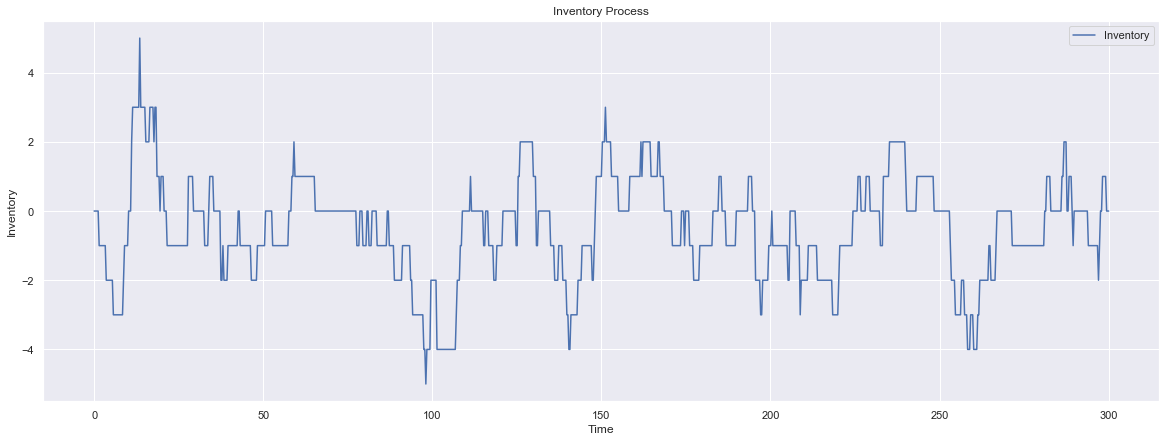

In [25]:
x1 = [1 for i in range(len(loc_buy))]
x2 = [-1 for i in range(len(loc_sell))]
plt.plot(S_t.iloc[:,0],inv_vals,label = 'Inventory')

plt.legend()
plt.title('Inventory Process')
plt.xlabel('Time')
plt.ylabel('Inventory')
plt.show()

### Expected Inventory Drift


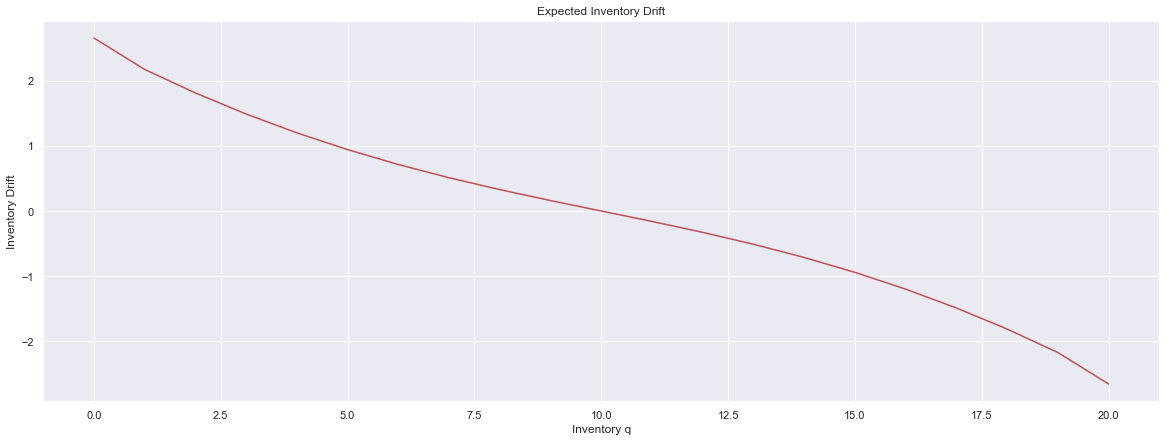

In [26]:
m = pd.DataFrame(Mu)
# Which Timestep to choose
t = 1
# Gets the Mu values for each inventory q at timestep t
m.iloc[t].plot(color='r')
plt.title('Expected Inventory Drift')
plt.ylabel('Inventory Drift')
plt.xlabel("Inventory q")
plt.show()

### Ranges for Optimal Buy and Sell LO Depths

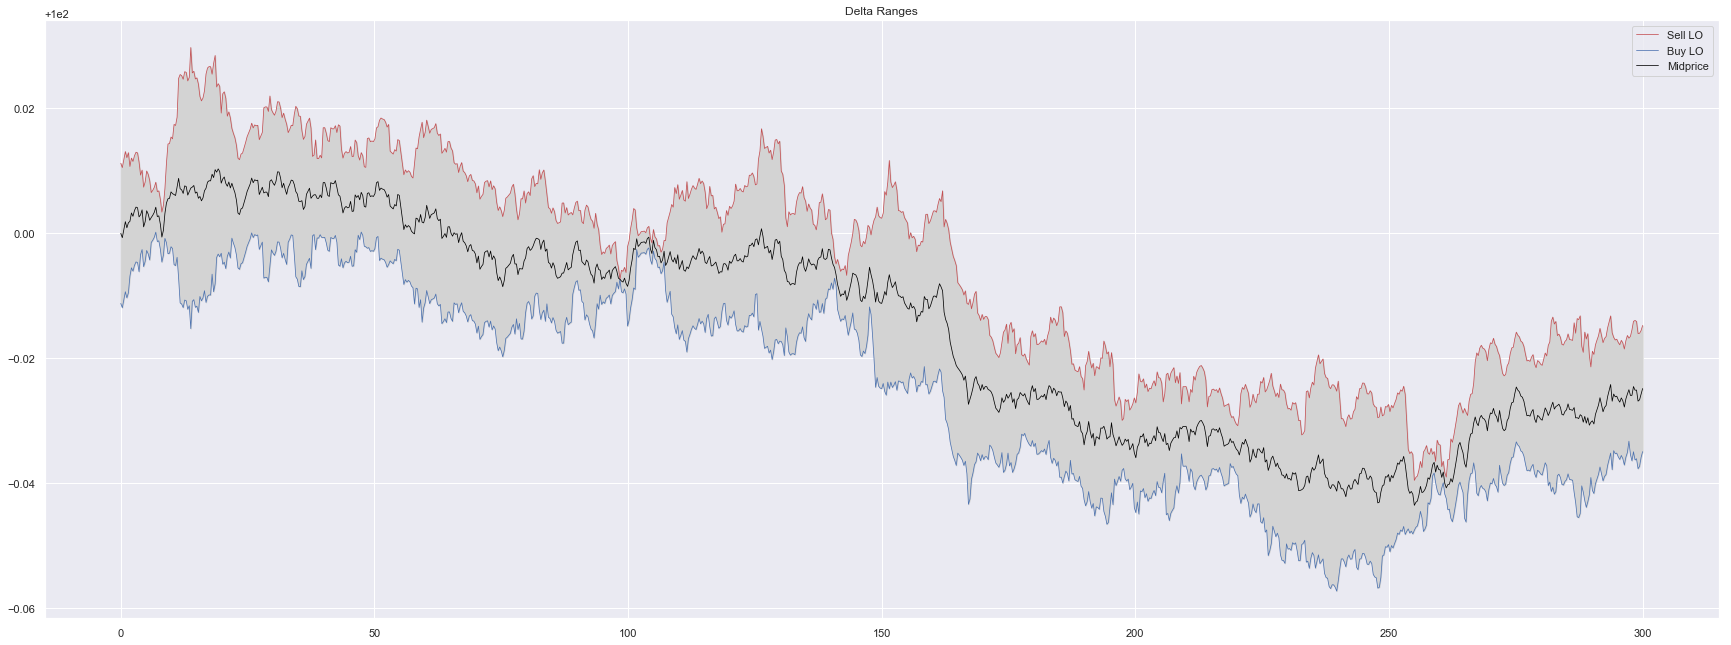

In [27]:
#Plotting Bound for Buy and Sell LO's
plt.rcParams["figure.figsize"] = (30,11)
plt.plot(S_t.iloc[:,0],path_delta_plus,label = 'Sell LO',color = 'r',linewidth=0.75)
plt.plot(S_t.iloc[:,0],path_delta_minus,label = 'Buy LO',color = 'b',linewidth=0.75)
plt.plot(S_t.iloc[:,0],S_t.iloc[:,1],label='Midprice',color = 'black',linewidth=0.75)
plt.fill_between(S_t.iloc[:,0],path_delta_plus,S_t.iloc[:,1],color = 'lightgrey')
plt.fill_between(S_t.iloc[:,0],path_delta_minus,S_t.iloc[:,1],color = 'lightgrey')
plt.title('Delta Ranges')
plt.legend()
plt.show()

### Filled Buy and Sell Market Orders

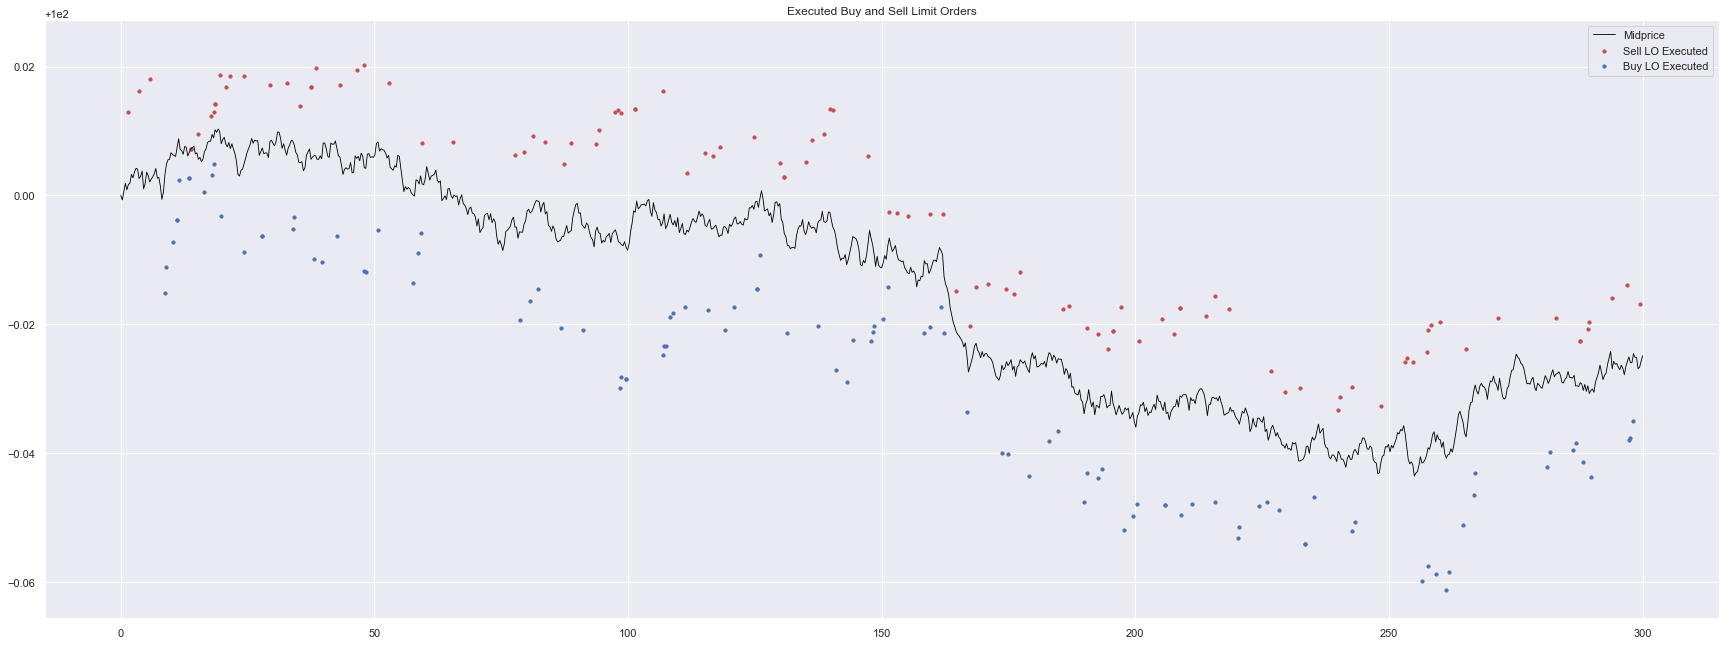

In [28]:
# Plotting the filled Buy and Sell Mo's
plt.rcParams["figure.figsize"] = (30,11)
plt.scatter(sell_lo_executed_x,sell_lo_executed_y,color = 'r',label = 'Sell LO Executed',s=10)
plt.scatter(buy_lo_executed_x,buy_lo_executed_y,color = 'b',label = 'Buy LO Executed',s=10)
plt.title("Executed Buy and Sell Limit Orders")
plt.plot(S_t.iloc[:,0],S_t.iloc[:,1],label='Midprice',color = 'black',linewidth=0.85)
plt.legend()
plt.show()

### Cash Process over Time

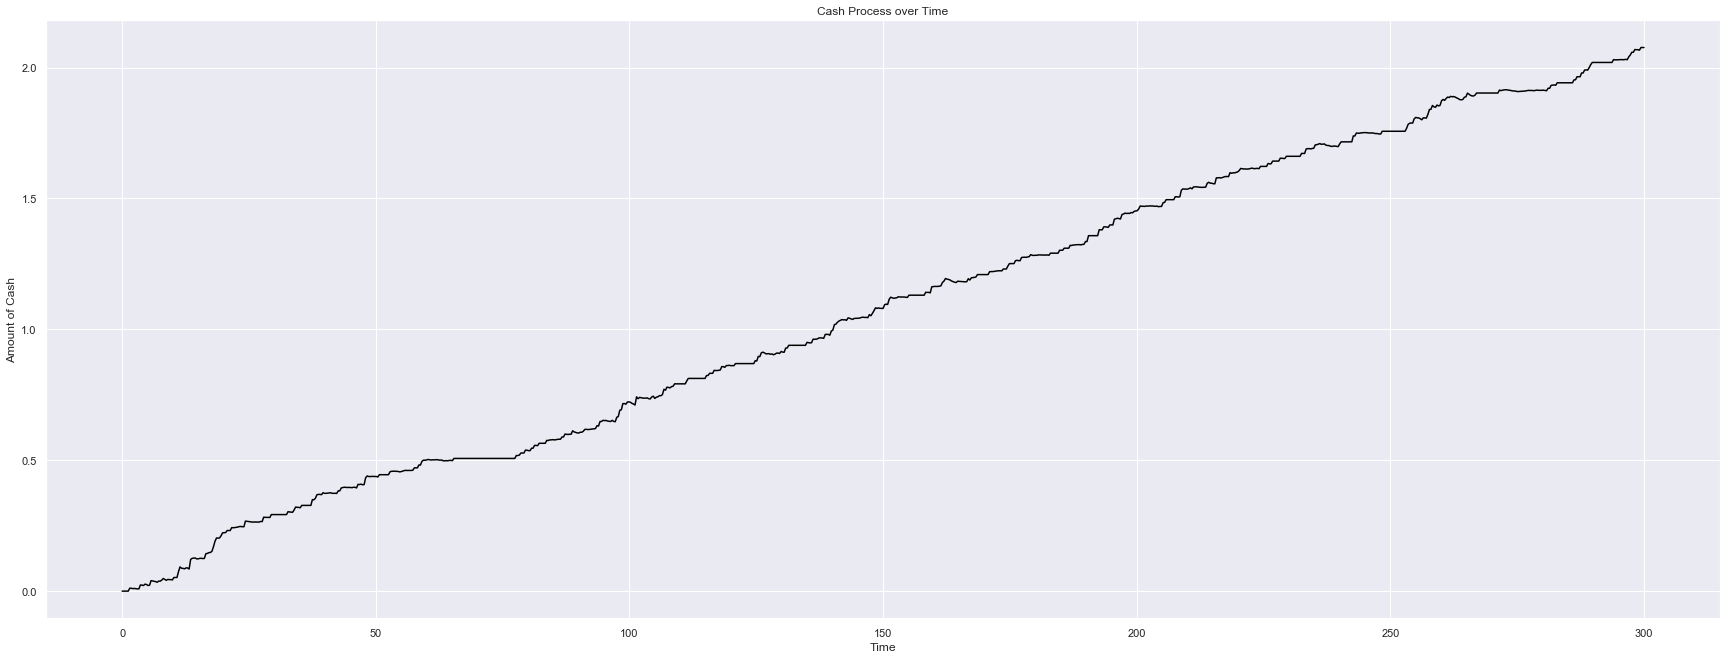

In [29]:
# Plotting the cash process
plt.plot(S_t.iloc[:,0],cash_path,label='Cash Process',color = 'black')
plt.xlabel("Time")
plt.ylabel("Amount of Cash")
plt.title("Cash Process over Time")
plt.show()